In [1]:
import imutils
import cv2
from  matplotlib import pyplot as plt

In [2]:
def scale_frame(scale: int, frm):

    width = int(frm.shape[1] * scale / 100)
    height = int(frm.shape[0] * scale / 100)
    dim = (width, height)
    frm = cv2.resize(frm, dim, interpolation=cv2.INTER_AREA)

    return frm

In [3]:
image = cv2.imread('images/1.png')
image = scale_frame(100, image)
image_text = image.copy()
image_checkbox = image.copy()
image_fields = image.copy()

# <div align="center">Sobel Transform</div>

In [4]:
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
depth = cv2.CV_32F if imutils.is_cv2() else cv2.CV_32F
gradX = cv2.Sobel(gray, ddepth=depth, dx=1, dy=0, ksize=-1)
gradY = cv2.Sobel(gray, ddepth=depth, dx=0, dy=1, ksize=-1)

gradient = cv2.subtract(gradX, gradY)
gradient = cv2.convertScaleAbs(gradient)

In [5]:
blurred = cv2.blur(gradient, (2, 2))
_, thresh = cv2.threshold(blurred, 225, 255, cv2.THRESH_BINARY)

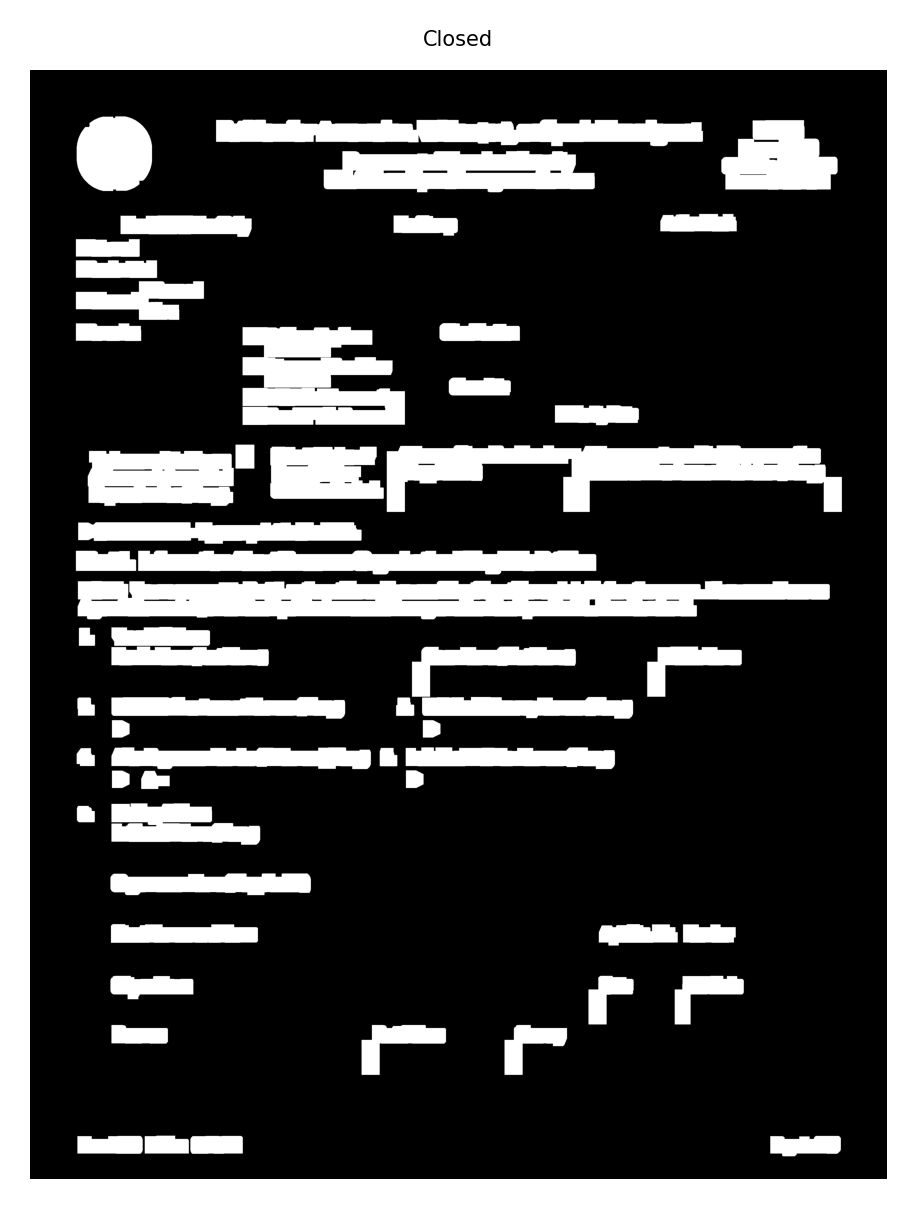

In [6]:
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (40, 5))
closed = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)

closed = cv2.erode(closed, None, iterations=3)
closed = cv2.dilate(closed, None, iterations=20)

plt.figure(dpi=300)
plt.imshow(closed, 'gray')
plt.axis('off') 
plt.title(label='Closed', fontsize=5)
plt.show()

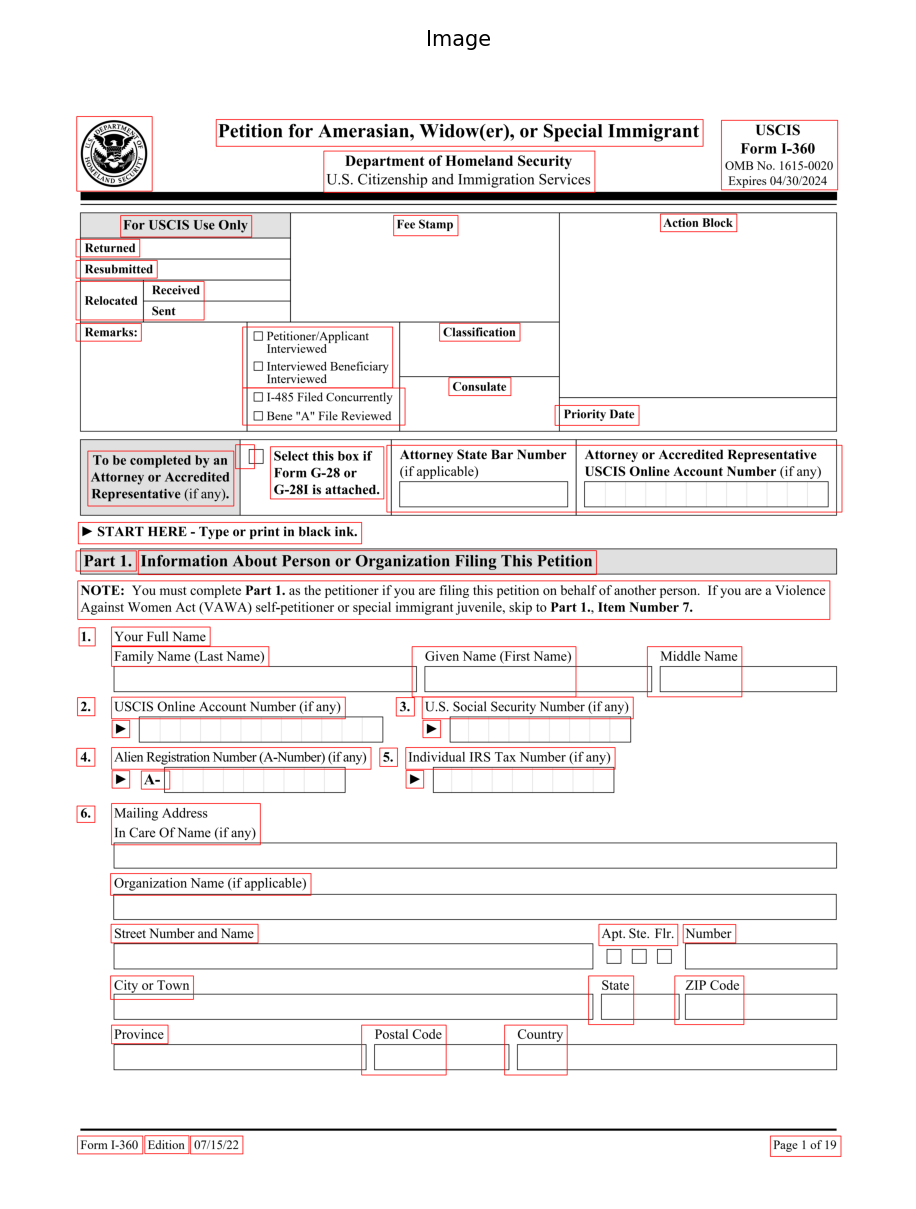

In [7]:
cnts, _ = cv2.findContours(closed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

list_of_textbox = []
w_indent = 0  # (px)
h_indent = 0  # (px)
width, height, _ = image_text.shape

for cnt in cnts:

    x, y, w, h = cv2.boundingRect(cnt)

    x1 = x - w_indent
    if x1 < 0:
        x1 = 0

    y1 = y - h_indent
    if y1 < 0:
        y1 = 0

    x2 = x + w + w_indent
    y2 = y + h + h_indent

    cv2.rectangle(image_text, (x1, y1), (x2, y2), (0, 0, 255), 2)
    list_of_textbox.append(image_text.copy()[y1: y2, x1: x2])

plt.figure(dpi=300)
plt.imshow(cv2.cvtColor(image_text, cv2.COLOR_BGR2RGB))
plt.axis('off') 
plt.title(label='Image', fontsize=5)
plt.show()

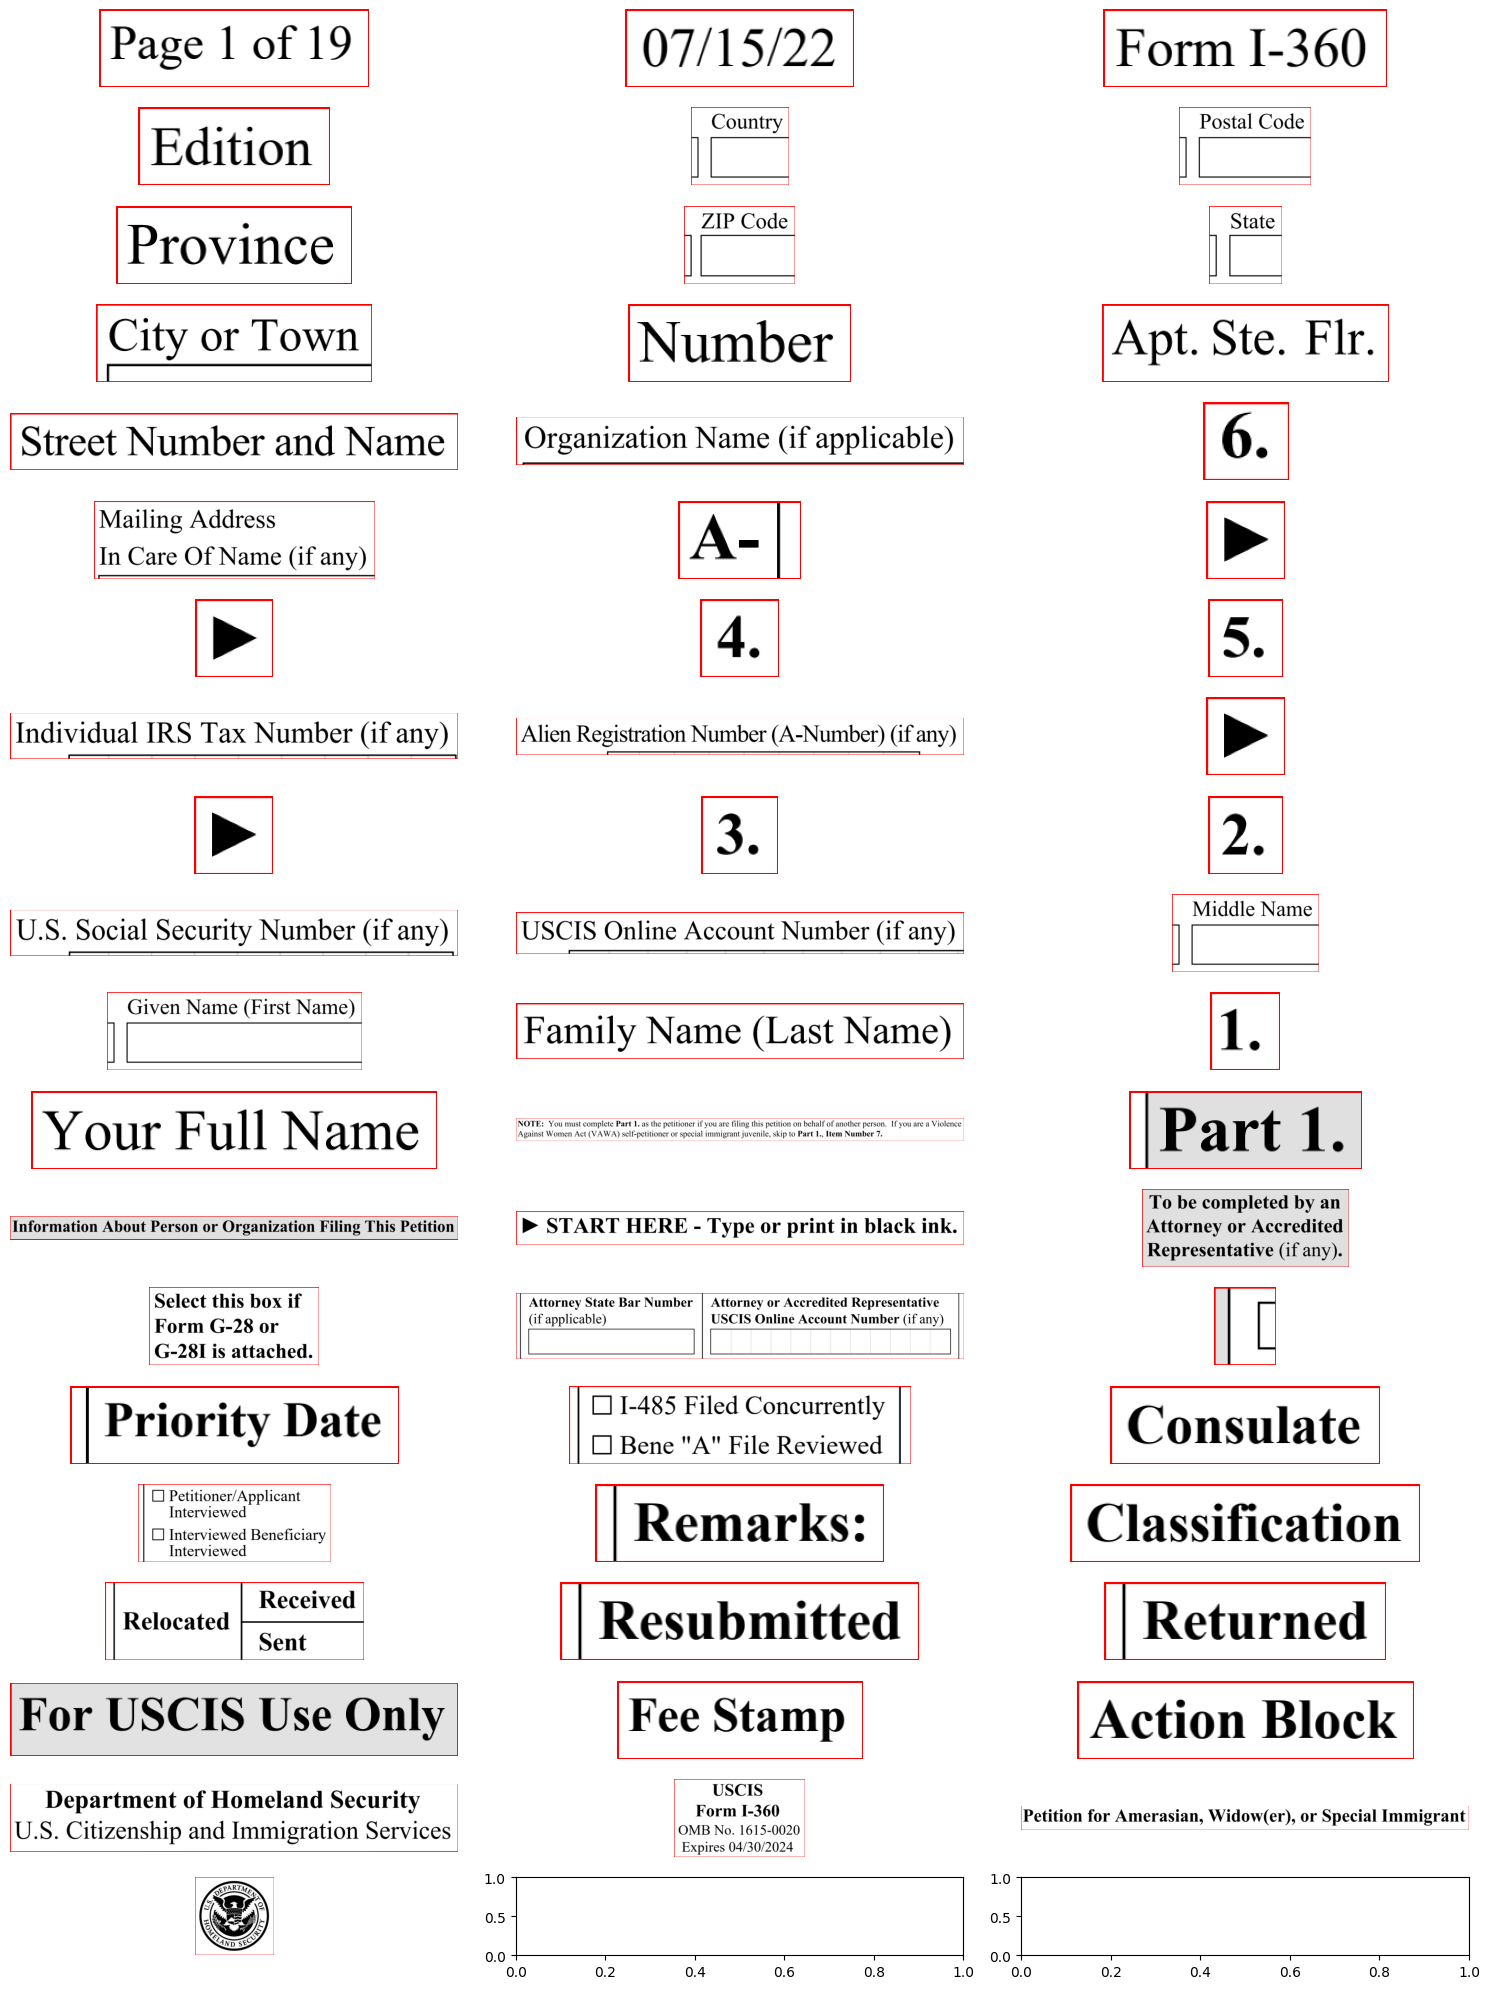

In [8]:
# Set the number of columns for display
num_cols = 3

# Calculate the number of rows needed
num_images = len(list_of_textbox)
num_rows = (num_images + num_cols - 1) // num_cols

# Create subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 1 * num_rows))

# Flatten the axes array if there's only one row
if num_rows == 1:
    axes = axes.reshape(1, -1)

# Iterate through the images and display them
for i, img in enumerate(list_of_textbox):
    row_idx = i // num_cols
    col_idx = i % num_cols
    ax = axes[row_idx, col_idx]

    # Display image
    ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    ax.axis('off')

# Adjust layout to prevent overlapping
plt.tight_layout()
plt.show()

# <div align="center">Checkbox finder</div>

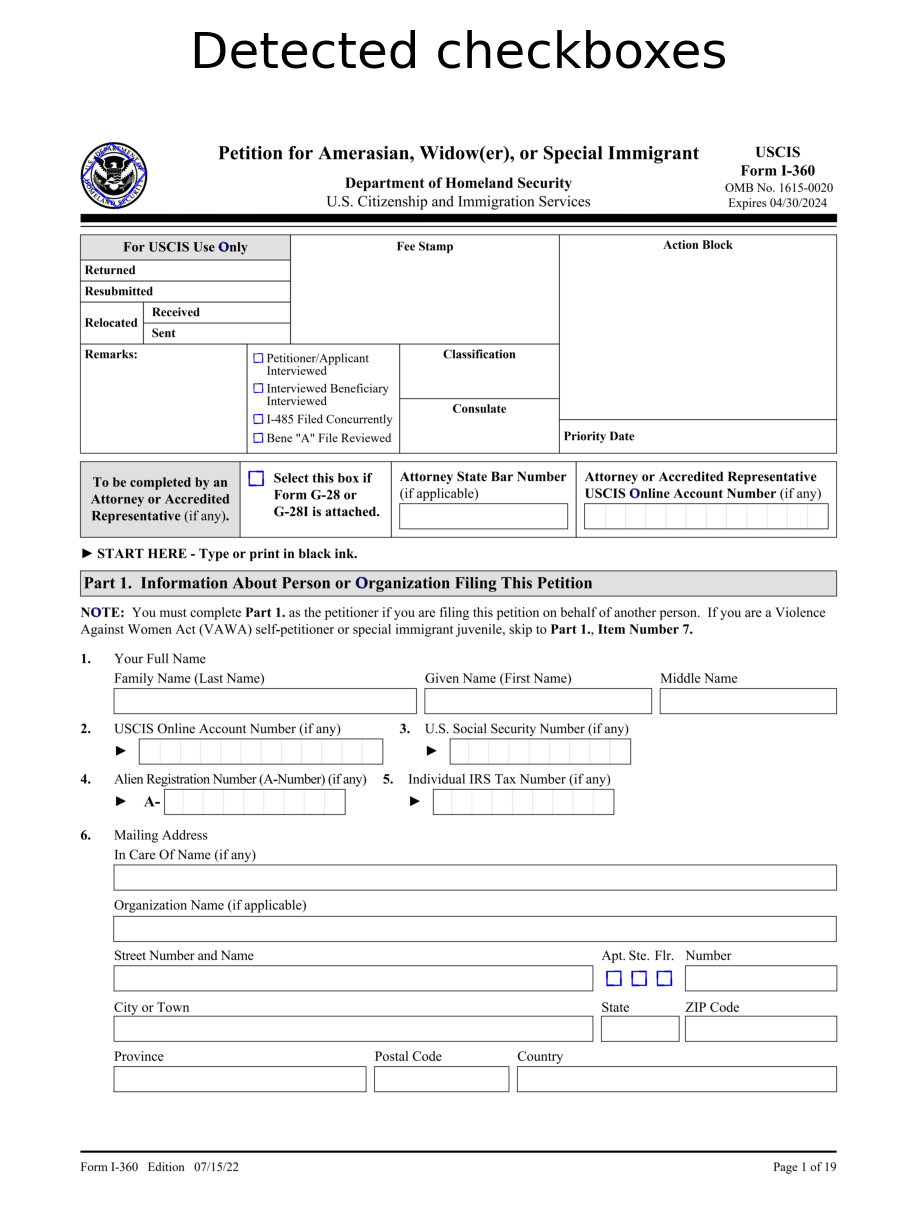

In [9]:
# Минимальная площадь для фильтрации маленьких контуров
min_contour_area = 1000

# Преобразование изображения в оттенки серого
gray = cv2.cvtColor(image_checkbox, cv2.COLOR_BGR2GRAY)

# Применение порогового значения для создания бинарного изображения (черно-белого)
_, threshold = cv2.threshold(gray, 30, 255, cv2.THRESH_BINARY)

# Поиск контуров в изображении
contours, _ = cv2.findContours(threshold, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)

# Минимальное и максимальное соотношение сторон для квадрата
min_aspect_ratio = 0.95
max_aspect_ratio = 1.05

# Фильтрация контуров, чтобы оставить только квадраты
squares = []
for contour in contours:
    perimeter = cv2.arcLength(contour, True)
    approx = cv2.approxPolyDP(contour, 0.1 * perimeter, True)
    
    # Проверка, является ли контур квадратом
    if len(approx) == 4:
        # Вычисление площади контура
        area = cv2.contourArea(contour)
        
        # Проверка, является ли площадь контура достаточно большой
        if area > min_contour_area:
            # Вычисление прямоугольника, описывающего контур
            x, y, w, h = cv2.boundingRect(approx)
            
            # Вычисление соотношения сторон
            aspect_ratio = float(w) / h
            
            # Проверка, является ли контур квадратом
            if min_aspect_ratio <= aspect_ratio <= max_aspect_ratio:
                squares.append(approx)
                cv2.drawContours(image_checkbox, [approx], 0, (255, 0, 0), 2)
        
# Отображение исходного и обработанного изображения
plt.figure(dpi=300)
plt.imshow(cv2.cvtColor(image_checkbox, cv2.COLOR_BGR2RGB)), plt.title('Detected checkboxes')
plt.axis('off') 
plt.show()

# <div align="center">Detection fields</div>

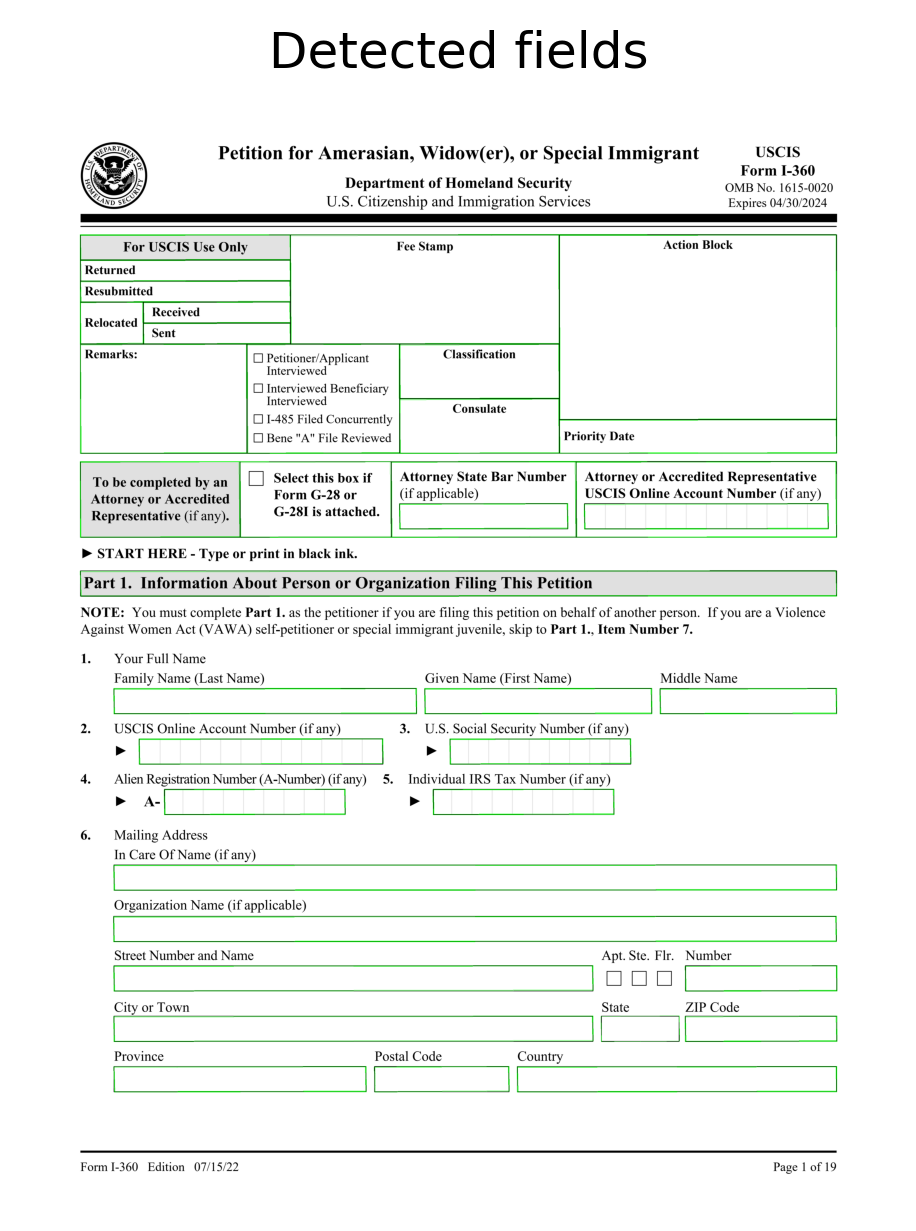

In [10]:
# Минимальная площадь для фильтрации маленьких контуров
min_contour_area = 5000

# Преобразование изображения в оттенки серого
gray = cv2.cvtColor(image_fields, cv2.COLOR_BGR2GRAY)

# Применение размытия для уменьшения шума
blurred = cv2.GaussianBlur(gray, (5, 5), 0)

# Детекция краев с использованием оператора Canny
edges = cv2.Canny(blurred, 50, 150)

# Поиск контуров в изображении
contours, _ = cv2.findContours(edges.copy(), cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)

# Фильтрация контуров, чтобы оставить только прямоугольники
rectangles = []
for contour in contours:
    perimeter = cv2.arcLength(contour, True)
    approx = cv2.approxPolyDP(contour, 0.01 * perimeter, True)
    
    # Проверка, является ли контур прямоугольником
    if len(approx) == 4:
        # Вычисление площади контура
        area = cv2.contourArea(contour)
        
        # Проверка, является ли площадь контура достаточно большой
        if area > min_contour_area:
            # Дополнительная проверка, чтобы исключить внешние контуры
            if cv2.pointPolygonTest(contour, (0, 0), False) < 0:
                rectangles.append(approx)
                cv2.drawContours(image_fields, [approx], 0, (0, 255, 0), 1)

# Отображение исходного и обработанного изображения
plt.figure(dpi=300)
plt.imshow(cv2.cvtColor(image_fields, cv2.COLOR_BGR2RGB)), plt.title('Detected fields')
plt.axis('off') 
plt.show()